In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Segmentation with Watershed algorithm

Thuật toán phân đoạn dựa trên thuật toán watershed gốc có thể được mô tả như sau: tại các điểm cực tiểu địa phương (local minima), thực hiện đổ nước với các màu khác nhau tại các cực tiểu đó. Tiếp theo, nâng dần mực nước lên, trong quá trình nâng lên đó, nước với hai màu có thể bị trộn lại, để tránh việc đó, thuật toán thực hiện xây lên các biên (đánh dấu vị trí xảy ra hiện tượng trộn màu là biên). Các biên đó chính là kết quả đầu ra cho thuật toán phân đoạn bằng watershed. 

Nhược điểm của thuật toán watershed này là kết quả có thể bị oversegmentation do ảnh có thể bị nhiễu dẫn đến các nhiều cực tiểu nhiễu. Có thể khắc phụ nhược điểm này thông qua cung cấp thông tin interactive từ người dùng ứng với các vùng trũng để bắt đầu việc đổ nước. 

Đó cũng chính là thuật toán được cái đặt trong OpenCV. Sử dụng thuật toán thông qua hàm `watershed` với tham số cần truyền
* `img` - ảnh gốc (có thể 3 kênh màu)
* `markers` - cùng kích thước với ảnh đầu vào, các pixel (mang giá trị dương > 0) cùng giá trị ứng với cùng một vùng được đổ nước cùng màu

Để xác định `markers` có thể bằng cách xác định các vùng chắc chắn là foreground của vật thể, các vùng chắc chắn là background của khung cảnh. Rồi sau đó thực hiện thuật toán watershed tại các vùng đó.

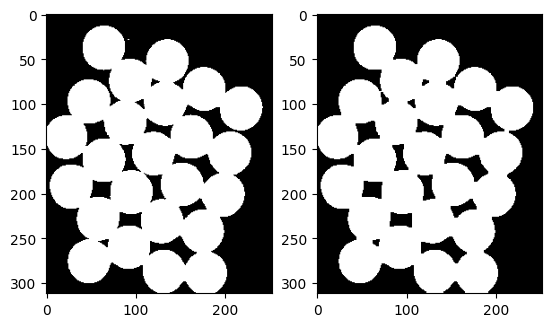

In [2]:
# chuẩn bị ảnh
img = cv.imread('images/water_coins.jpg')

# threshold thành ảnh nhị phân
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, img_bw = cv.threshold(img_gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

plt.subplot(1, 2, 1)
plt.imshow(img_bw, cmap='gray', vmin=0, vmax=255)

# khử các nhiễu, điểm trắng nằm bên ngoài vật thể bằng các phép toán morphological opening
img_bw = cv.morphologyEx(img_bw, cv.MORPH_OPEN, kernel=np.ones((3, 3), np.uint8))


# khử các nhiễu, điểm trắng nằm bên ngoài vật thể bằng các phép toán morphological closing
img_bw = cv.morphologyEx(img_bw, cv.MORPH_CLOSE, kernel=np.ones((3, 3), np.uint8))

plt.subplot(1, 2, 2)
plt.imshow(img_bw, cmap='gray', vmin=0, vmax=255)


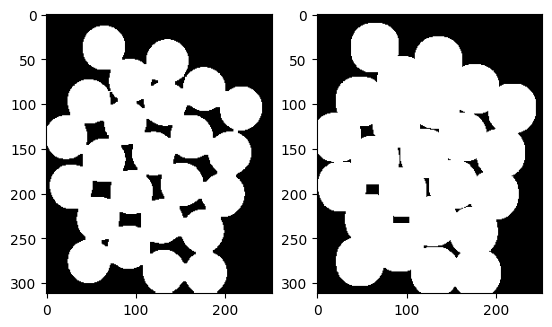

In [3]:
# xác định vùng chắc chắn là background
sure_bg = cv.dilate(img_bw, kernel=np.ones((3, 3), np.uint8), iterations=3)

plt.subplot(1, 2, 1)
plt.imshow(img_bw, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(sure_bg, cmap='gray', vmin=0, vmax=255)

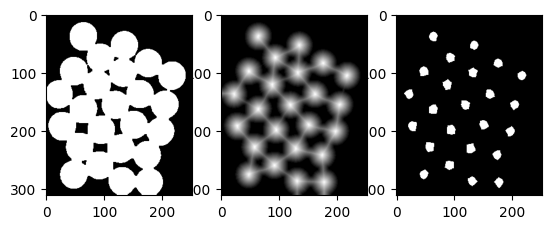

In [4]:
# xác định vùng chắc chắn là foreground - các pixel có khoảng cách tới background lớn
# tính theo khoảng cách L2 và ma trận hàng xóm kích thước 5x5
dist_mat = cv.distanceTransform(img_bw, cv.DIST_L2, 5)
ret, sure_fg = cv.threshold(dist_mat, 0.7 * dist_mat.max(), 255, cv.THRESH_BINARY)

plt.subplot(1, 3, 1)
plt.imshow(img_bw, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 3, 2)
plt.imshow(255 * dist_mat / dist_mat.max(), cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 3, 3)
plt.imshow(sure_fg, cmap='gray', vmin=0, vmax=255)

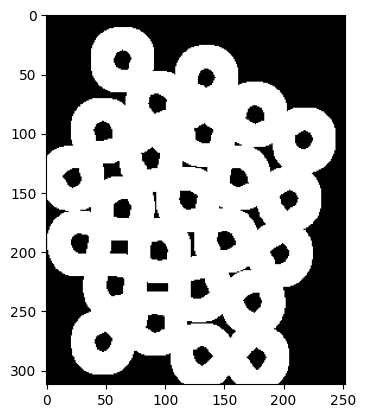

In [5]:
# vùng chưa xác định để phân
unknown = sure_bg - sure_fg
plt.imshow(unknown, cmap='gray', vmin=0, vmax=255)

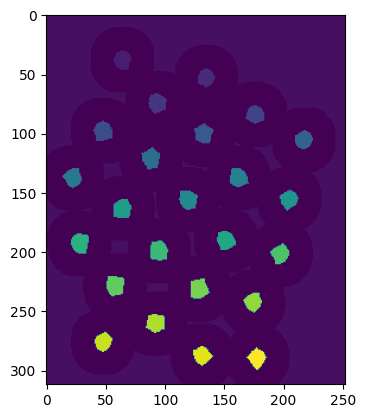

In [6]:
# xác định các thành phần liên thông trong ảnh
# các vùng đồng xu được đánh số riêng biệt, cùng với background (trong trường hợp ảnh này)
ret, markers = cv.connectedComponents(sure_fg.astype(np.uint8))

markers = markers + 1 # tất cả các vùng có index > 0 sẽ thực hiện đổ nước
markers[unknown == 255] = 0 # vùng không đổ nước trong thuật toán watershed

plt.imshow(markers)

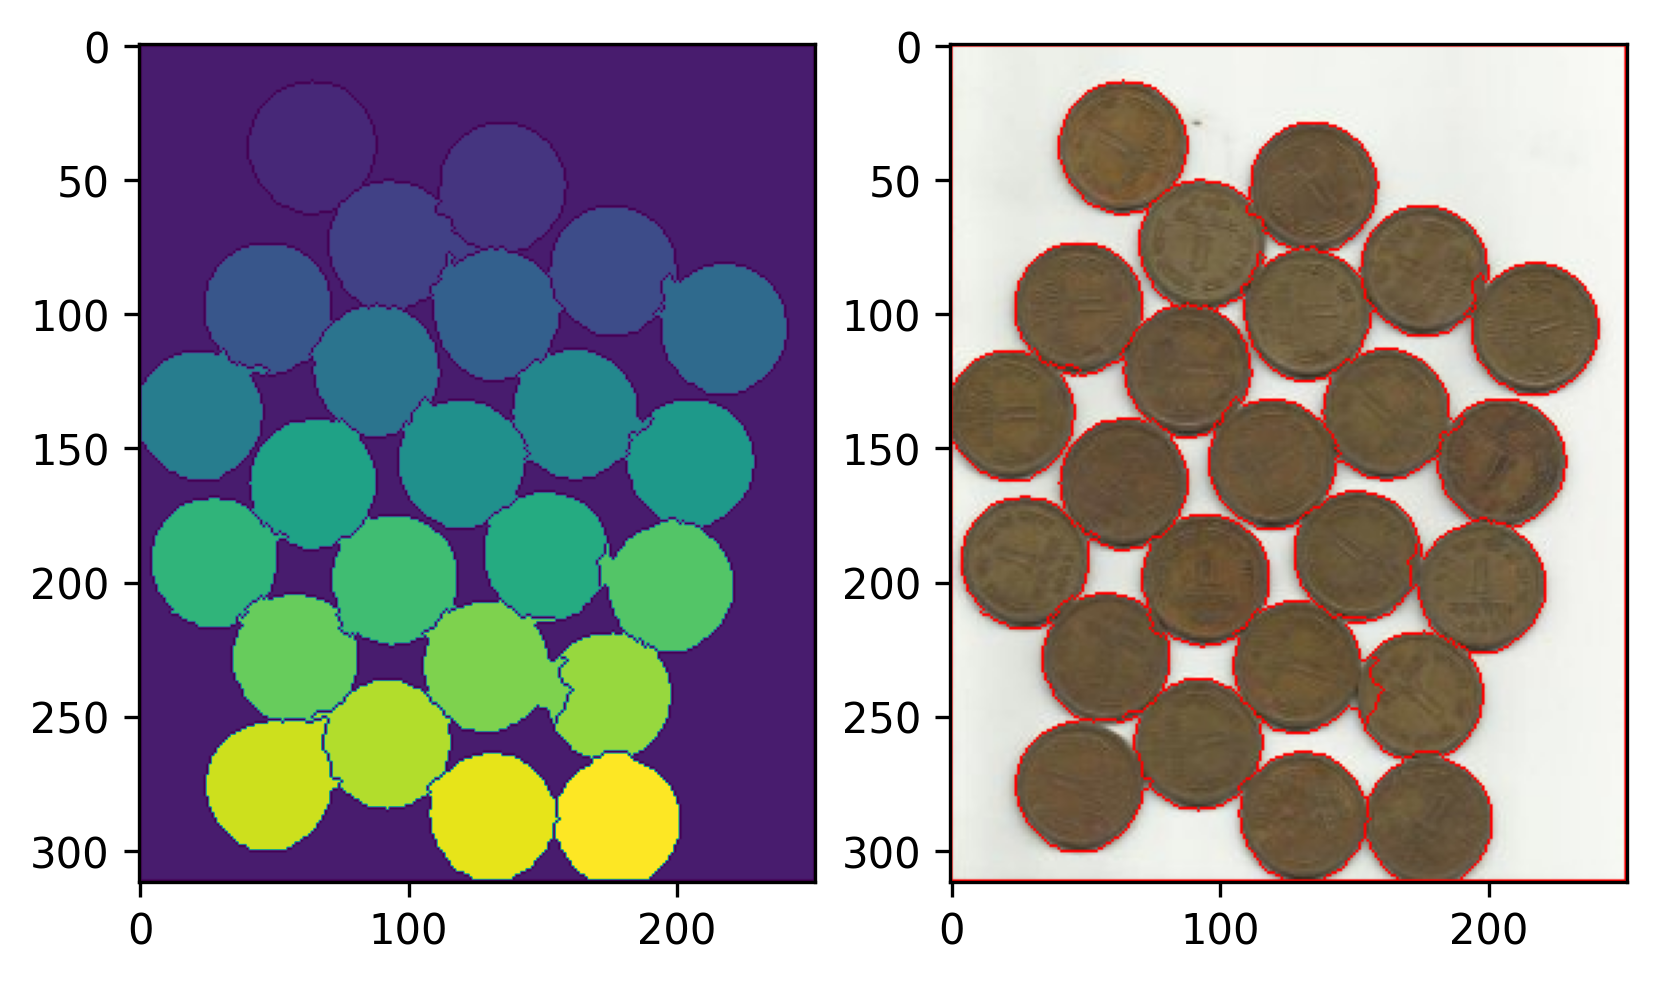

In [7]:
segmented = cv.watershed(img, markers)

fin = img.copy()
fin[segmented == -1] = [0, 0, 255] # các điểm biên được đánh dấu bằng -1 trong thuật toán watershed được xây dựng trong opencv

plt.rcParams['figure.dpi'] = 300
plt.subplot(1, 2, 1)
plt.imshow(segmented)
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(fin, cv.COLOR_BGR2RGB))